In [46]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import cv2
import time
import sys
import re
from copy import deepcopy
from collections import defaultdict
from itertools import islice
from tqdm import tqdm_notebook
from time import time
from easydict import EasyDict
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from warnings import filterwarnings

import torch
from torch import nn
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

from mvn.datasets.human36m import Human36MMultiViewDataset
from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy
from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose, display_pose
from mvn.utils import img, multiview, volumetric, op, vis, misc, cfg
from mvn.datasets import utils as dataset_utils

from train_decomposition import setup_human36m_dataloaders

device = 'cuda:0' #torch.cuda.current_device()

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calculate

In [47]:
config_path = './experiments/human36m/train/human36m_vol_baseline.yaml'
config = cfg.load_config(config_path)
num_joints = config.model.backbone.num_joints

In [48]:
train_loader, val_loader, _ = setup_human36m_dataloaders(config, is_train=True, distributed_train=False)

for batch in train_loader:
    images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch = dataset_utils.prepare_batch(batch, device)
    break

In [49]:
keypoints_3d = train_loader.dataset.labels['table']['keypoints']
N_train = keypoints_3d.shape[0]

In [50]:
N_train

389938

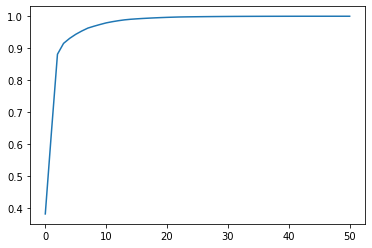

In [51]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from tensorly.decomposition import tucker

pca = PCA()
scaler = StandardScaler()
X = keypoints_3d.reshape(N_train, -1)
X_scaled = scaler.fit_transform(X)
pca.fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Visualize

In [51]:
# keypoints_pca_unscaled = scaler.inverse_transform(pca.components_).reshape(51,17,3)
# keypoints_pca_unscaled.shape

(51, 17, 3)

In [7]:
# VOLUME_SIZE = 32
# coord_volumes, _, base_points = op.get_coord_volumes(kind=train_loader.dataset.kind,
#                                                         training=False,
#                                                         rotation=False,
#                                                         cuboid_side=2500,
#                                                         volume_size=VOLUME_SIZE,
#                                                         device='cuda:0',
#                                                         keypoints=keypoints_pca_unscaled,
#                                                         batch_size=None,
#                                                         dt=None,
#                                                         )

In [37]:
# component_number = 20
# display_pose(coord_volumes[component_number].detach().cpu().numpy(),
#              keypoints_pca_unscaled[component_number]) # keypoints, 

# Tucker

In [8]:
from tensorly.decomposition import tucker, mps_decomposition
from IPython.display import clear_output

$$H\left(n, j, x, y, z\right)=\sum_{\alpha_{0}, \ldots, \alpha_{5}} G_{1}\left(\alpha_{0}, n, \alpha_{1}\right) G_{2}\left(\alpha_{1}, j, \alpha_{2}\right) G_{3}\left(\alpha_{2}, x, \alpha_{3}\right) G_{4}\left(\alpha_{3}, y, \alpha_{4}\right) G_{5}\left(\alpha_{4}, z, \alpha_{5}\right)$$

In [8]:
# keypoints_pca_unscaled_tensor = torch.tensor(keypoints_pca_unscaled, device=device)
# coord_volumes_pca, _, base_points_pred = op.get_coord_volumes(config.model.kind, 
#                                                             False, 
#                                                             False,
#                                                             config.model.cuboid_side,
#                                                             64, # config.model.volume_size
#                                                             device,
#                                                             keypoints=keypoints_pca_unscaled_tensor
#                                                             )
    

# heatmaps_pca = op.make_3d_heatmap(coord_volumes_pca, keypoints_pca_unscaled_tensor)

In [9]:
# core, factors = tucker(to_numpy(heatmaps_pca))
# factors_tensor = [torch.tensor(t) for t in factors[1:]]
# torch.save(factors_tensor, './basis/heatmaps64_3d_euclidean_convgauss_var0.5_kernel5_Tucker-factors-normalized')

In [20]:
# %%time
# heatmaps_3d = torch.load('./basis/heatmaps32_3d_euclidean_convgauss_var0.5_kernel5_Tucker-factors-normalized')
# heatmaps_3d_basis = heatmaps_3d #[:20]
# core, factors = tucker(heatmaps_3d_basis.numpy())

# Tucker optimization

In [19]:
factors_tensor = torch.load('./basis/heatmaps32_3d_euclidean_convgauss_var0.5_kernel5_Tucker-factors-normalized')
# factors_tensors_random = [torch.randn(*t.shape, device=device) for t in factors_tensor]

mpjpe = []

batch_size=10
# first_factor = nn.Parameter(data=torch.randn(batch_size, batch_size, device=device))#.to(device)

indexes = np.random.choice(np.arange(keypoints_3d.shape[0]), size=batch_size)
keypoints_3d_gt = torch.tensor(keypoints_3d[indexes]).to(device)

In [23]:
rangs_loss = defaultdict(list)
for r in tqdm_notebook([4,10,20,32]):
    
    core_tensor = nn.Parameter(data=torch.randn((batch_size, config.model.backbone.num_joints, r, r, r),
                                                device=device)).to(device)
    optimizer = torch.optim.Adam([core_tensor])
    
    coord_volumes_pred, _, base_points_pred = op.get_coord_volumes(config.model.kind, 
                                                                False, 
                                                                False,
                                                                config.model.cuboid_side,
                                                                config.model.volume_size, 
                                                                device,
                                                                keypoints=keypoints_3d_gt
                                                                )
    
    # x+1 if x >= 45 else x+5
    factors_tensors_r = [t[:r].to(device) if i>0 else t.to(device) for i,t in enumerate(factors_tensor)]

    for t in range(100):
        #core (20, 17, 32, 32, 32)
        # f1 (20,20)
#         T1 = torch.einsum('njxyz,nb->bjxyz', core_tensor, first_factor)
        T2 = torch.einsum('bjxyz,ji->bixyz', core_tensor, factors_tensors_r[0])
        T3 = torch.einsum('bixyz,xk->bikyz', T2, factors_tensors_r[1])
        T4 = torch.einsum('bikyz,yl->biklz', T3, factors_tensors_r[2])
        T = torch.einsum('biklz,zm->biklm', T4, factors_tensors_r[3])
        keypoints_3d_pred, _ = op.integrate_tensor_3d_with_coordinates(T,
                                                                       coord_volumes_pred,
                                                                       softmax=True)

        pjpe = torch.sqrt(((keypoints_3d_gt - keypoints_3d_pred) ** 2).sum(2)).mean(1).mean()
        loss = pjpe
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        rangs_loss[r].append(loss.item())

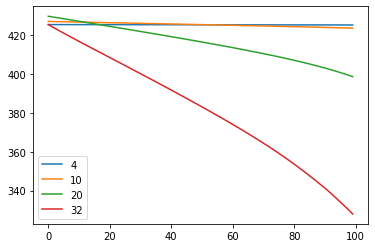

In [24]:
for r,losses in rangs_loss.items():
    plt.plot(losses, label='{}'.format(r))
plt.legend()
plt.show()

In [89]:
# grads = core_tensor.grad.abs()
# (grads > grads.median()).sum() / core_tensor.numel()

tensor(0, device='cuda:0')

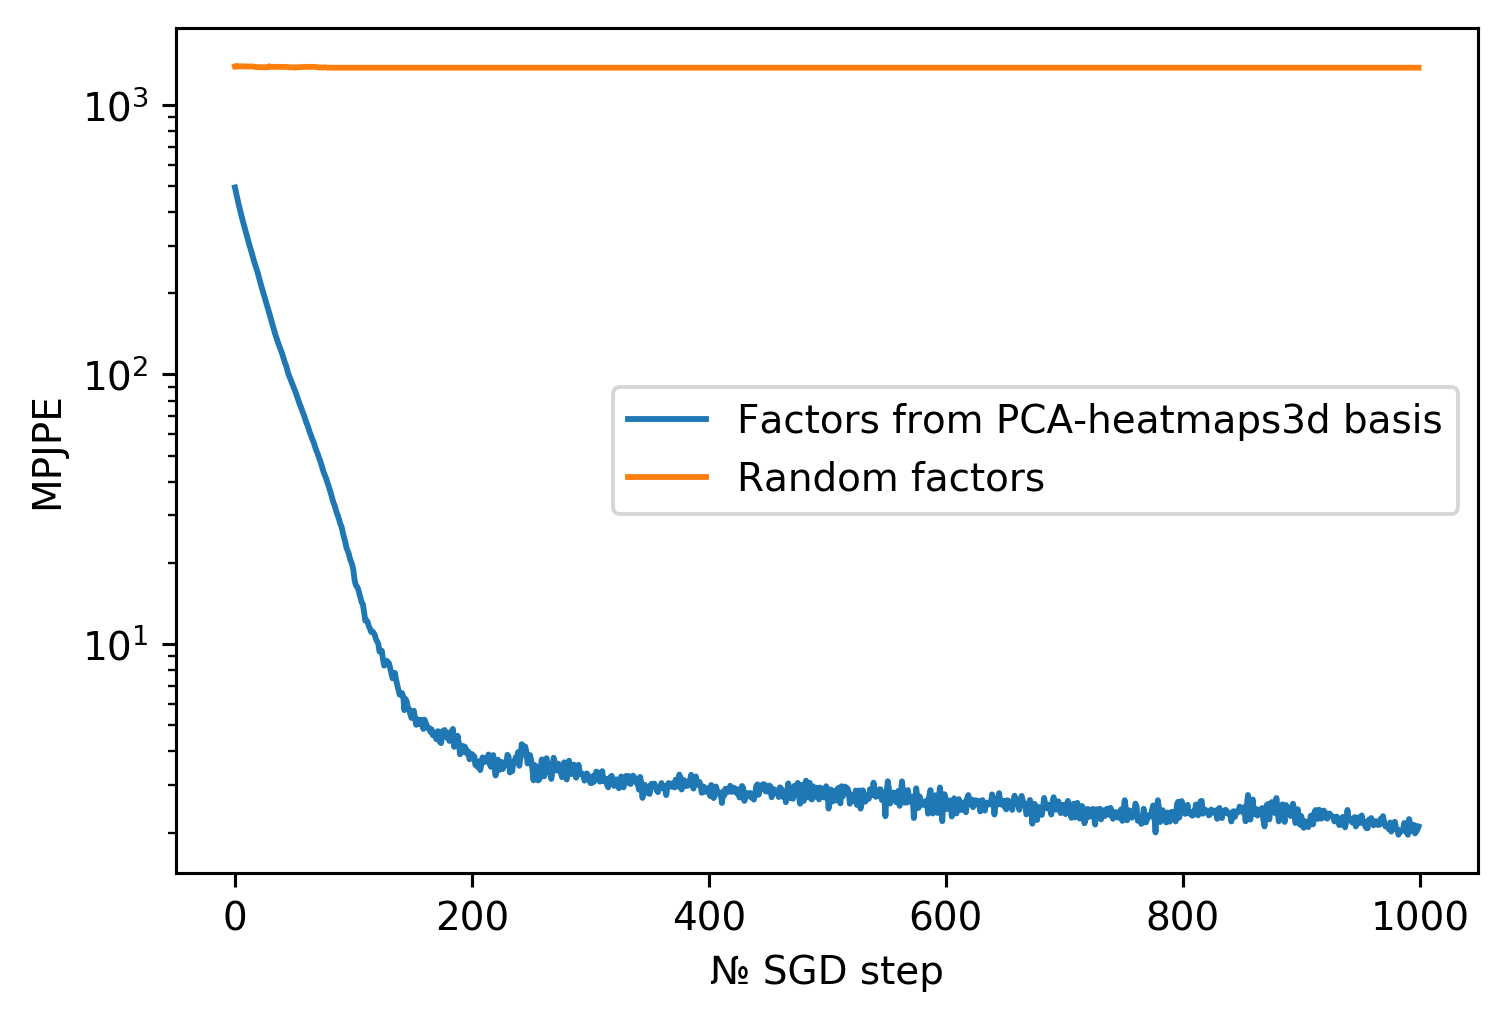

In [111]:
# plt.figure(dpi=280)
# plt.plot(losses_orig, label='Factors from PCA-heatmaps3d basis')
# plt.plot(losses, label='Random factors')
# plt.xlabel('№ SGD step')
# plt.ylabel('MPJPE')
# plt.yscale('log')
# plt.legend()
# plt.show()

# SVD Precalc optimization

In [10]:
# n_basis = 20
# basis = torch.load('./basis/heatmaps32_3d_euclidean_convgauss_var0.5_kernel5')[:n_basis].to(device)
# # basis = torch.randn_like(basis)

# losses_svd = []
# batch_size=10

# core_tensor = nn.Parameter(data=torch.randn(batch_size, *basis.shape, device=device))#.to(device)
# optimizer = torch.optim.Adam([core_tensor])

# indexes = np.random.choice(np.arange(keypoints_3d.shape[0]), size=batch_size)
# keypoints_3d_gt = torch.tensor(keypoints_3d[indexes]).to(device)

In [11]:


# coord_volumes_pred, _, base_points_pred = op.get_coord_volumes(config.model.kind, 
#                                                             False, 
#                                                             False,
#                                                             config.model.cuboid_side,
#                                                             config.model.volume_size, 
#                                                             device,
#                                                             keypoints=keypoints_3d_gt
#                                                             )

# for t in tqdm_notebook(range(10000)):
#     #core (bs, 20, 17, 32, 32, 32)
#     T = torch.einsum('bnjxyz,bnjxyz->bjxyz', core_tensor, basis.unsqueeze(0).repeat(batch_size,1,1,1,1,1))
#     keypoints_3d_pred, _ = op.integrate_tensor_3d_with_coordinates(T,
#                                                                    coord_volumes_pred,
#                                                                    softmax=True)

#     pjpe = torch.sqrt(((keypoints_3d_gt - keypoints_3d_pred) ** 2).sum(2)).mean(1).mean()
#     loss = pjpe
#     optimizer.zero_grad()
#     loss.backward()        
#     optimizer.step()
#     losses.append(loss.item())


In [133]:
# losses_svd_orig = losses_svd

# SDV keypoints

In [155]:
n_basis = 20
basis = torch.load('./basis/3dkeypoints_pca')[:n_basis].to(device)
# basis = torch.randn_like(basis)

losses_svd_kp = []
batch_size=10

core_tensor = nn.Parameter(data=torch.randn(batch_size, *basis.shape,  device=device))#.to(device)
optimizer = torch.optim.Adam([core_tensor])

indexes = np.random.choice(np.arange(keypoints_3d.shape[0]), size=batch_size)
keypoints_3d_gt = torch.tensor(keypoints_3d[indexes]).to(device)

In [161]:
core_tensor.shape

torch.Size([10, 20, 51])

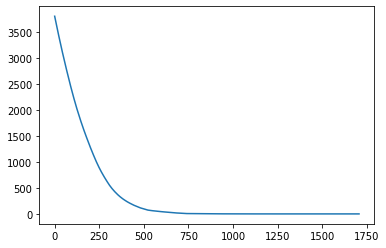

In [156]:
coord_volumes_pred, _, base_points_pred = op.get_coord_volumes(config.model.kind, 
                                                            False, 
                                                            False,
                                                            config.model.cuboid_side,
                                                            config.model.volume_size, 
                                                            device,
                                                            keypoints=keypoints_3d_gt
                                                            )

for t in tqdm_notebook(range(5000)):
    keypoints_3d_pred = torch.einsum('bnj,bnj->bj', 
                                     core_tensor,#core_tensor.unsqueeze(-1).repeat(1,1,basis.shape[-1]), 
                                     basis.unsqueeze(0).repeat(batch_size,1,1))
    keypoints_3d_pred = keypoints_3d_pred.view(batch_size, num_joints, -1)
            
    loss = torch.sqrt(((keypoints_3d_gt - keypoints_3d_pred) ** 2).sum(2)).mean(1).mean()
    optimizer.zero_grad()
    loss.backward()        
    optimizer.step()
    losses_svd_kp.append(loss.item())
    
clear_output()
plt.plot(losses_svd_kp)

In [35]:
keypoints_3d.shape

(389938, 17, 3)

# TT optimization

In [43]:
losses_tt = []
batch_size=10
dv = config.model.volume_size

rangs_loss = defaultdict(list)
for rank in tqdm_notebook([1,10,25]):
    
    indexes = np.random.choice(np.arange(keypoints_3d.shape[0]), size=batch_size)
    keypoints_3d_gt = torch.tensor(keypoints_3d[indexes]).to(device)
    
    coord_volumes, _, base_points_pred = op.get_coord_volumes(config.model.kind, 
                                                                False, 
                                                                False,
                                                                config.model.cuboid_side,
                                                                dv, 
                                                                device,
                                                                keypoints=keypoints_3d_gt
                                                                )
    
    tensors = nn.ParameterList([nn.Parameter(torch.randn(batch_size,17,rank)),
                                nn.Parameter(torch.randn(batch_size,rank,dv,rank)),
                               nn.Parameter(torch.randn(batch_size,rank,dv,rank)),
                               nn.Parameter(torch.randn(batch_size,rank,dv))]).to(device)
    
#         tensors = nn.ParameterList([nn.Parameter(torch.randn(batch_size,17,dv,rank)),
#                                nn.Parameter(torch.randn(batch_size,17,rank,dv,rank)),
#                                nn.Parameter(torch.randn(batch_size,17,rank,dv))]).to(device)
    
    optimizer = torch.optim.Adam(tensors.parameters())

    for t in tqdm_notebook(range(1000)):
        volume = op.compose(None, tensors, decomposition_type='tt', joint_independent=False)
        keypoints_3d_pred, _ = op.integrate_tensor_3d_with_coordinates(volume,
                                                                        coord_volumes,
                                                                        softmax=False)
        keypoints_3d_pred = keypoints_3d_pred.view(batch_size, num_joints, -1)

        loss = torch.sqrt(((keypoints_3d_gt - keypoints_3d_pred) ** 2).sum(2)).mean(1).mean()
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        rangs_loss[rank].append(loss.item())

    clear_output()

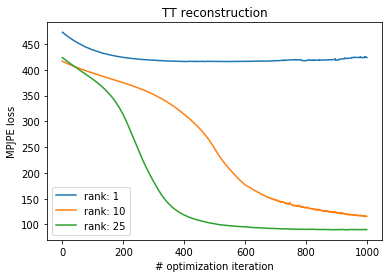

In [44]:
for r,losses in rangs_loss.items():
    plt.plot(losses, label='rank: {}'.format(r))
plt.legend()
plt.title('TT reconstruction')
plt.ylabel('MPJPE loss')
plt.xlabel('# optimization iteration')
plt.show()

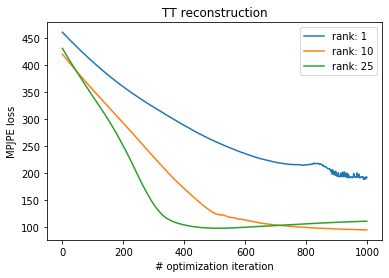

In [40]:
for r,losses in rangs_loss.items():
    plt.plot(losses, label='rank: {}'.format(r))
plt.legend()
plt.title('TT reconstruction')
plt.ylabel('MPJPE loss')
plt.xlabel('# optimization iteration')
plt.show()

In [53]:
from tensorly.decomposition import matrix_product_state
import tensorly

In [161]:
losses = defaultdict(list)
ranks = np.linspace(1,30, dtype=int)
for i in  tqdm_notebook(range(10)):
    keypoints_3d_gt = torch.tensor(keypoints_3d[i:i+1]).to(device)
    coord_volumes, _, base_points = op.get_coord_volumes(kind=train_loader.dataset.kind,
                                                        training=False,
                                                        rotation=False,
                                                        cuboid_side=config.model.cuboid_side,
                                                        volume_size=config.model.volume_size,
                                                        device='cuda:0',
                                                        keypoints=keypoints_3d_gt,
                                                        batch_size=None,
                                                        dt=None,
                                                        )
    X = op.make_3d_heatmap(coord_volumes,keypoints_3d_gt)
    
    for rank in ranks:
        factors = matrix_product_state(to_numpy(X[0]),rank=int(rank))

        f1,f2,f3,f4 = factors
        f1 = torch.from_numpy(f1.copy())
        f2 = torch.tensor(f2.copy()).unsqueeze(0)
        f3 = torch.tensor(f3.copy()).unsqueeze(0)
        f4 = torch.tensor(f4.copy()).unsqueeze(0).squeeze(-1)
        result = op.compose(None, [f1,f2,f3,f4] ,decomposition_type='tt')
        losses[i].append((result - X.detach().cpu()).abs().mean())

/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/tensorly/backend/core.py:728: RuntimeWarning:

invalid value encountered in less_equal



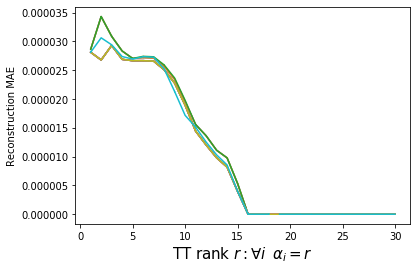

In [176]:
for i in range(len(losses)):    
    plt.plot(ranks, losses[i])
plt.ylabel('Reconstruction MAE')
plt.xlabel(r'TT rank $r:\forall i \,\,\, \alpha_i=r$', fontsize=15)
plt.show()